In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [2]:
# Splitting MNIST dataset into train and test sets
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 170266652.65it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92118398.35it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 94576292.60it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18622217.76it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [3]:
def same_padding(kernel_size, stride=1):
    # For odd dimensions, we can pad evenly on both sides
    # For even dimensions, we will pad one more on the right/bottom side
    pad_val = (kernel_size - stride) // 2
    return (pad_val, pad_val + (kernel_size % 2 - 1))


def create_sparse_representations(batch, sparsity=0.5):
    # Function to create sparse representations and masks for a batch of images
    masks = torch.bernoulli(torch.ones_like(batch) * (1 - sparsity))
    sparse_batch = batch * masks
    return sparse_batch, masks


In [ ]:
class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bias = torch.rand_like(torch.Tensor(out_channels)).to('cuda')

    def forward(self, input, mask):
        # Create a new mask
        new_mask = F.conv2d(mask, torch.ones_like(self.conv.weight), None, self.conv.stride, self.conv.padding)
        valid_pixel_amount = new_mask.clone().detach()
        # Apply convolution to the input
        output = self.conv(input * mask) * (self.conv.kernel_size[0] * self.conv.kernel_size[1])
        output = output.div(torch.add(valid_pixel_amount, 1e-5))
        output = output + self.bias.view(1,-1,1,1)

        new_mask = torch.ceil(new_mask.clamp_(0, 1))

        return output, new_mask

class SparseInvariantCNN(nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.features = nn.Sequential(
    #         SparseConv2d(1, 16, kernel_size=11, padding=same_padding(11)),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
    #         SparseConv2d(16, 16, kernel_size=7, padding=same_padding(7)),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
    #         SparseConv2d(16, 16, kernel_size=5, padding=same_padding(5)),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
    #         SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
    #         SparseConv2d(16, 16, kernel_size=3, padding=same_padding(3)),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
    #         SparseConv2d(16, 10, kernel_size=1, padding=same_padding(1)),
    #         nn.ReLU()
    #     )

    def __init__(self):
      super().__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=11, padding=same_padding(11)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=11, stride=1, padding=same_padding(11)),
        nn.Conv2d(16, 16, kernel_size=7, padding=same_padding(7)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=7, stride=1, padding=same_padding(7)),
        nn.Conv2d(16, 16, kernel_size=5, padding=same_padding(5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=1, padding=same_padding(5)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 16, kernel_size=3, padding=same_padding(3)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=1, padding=same_padding(3)),
        nn.Conv2d(16, 10, kernel_size=1, padding=same_padding(1)),
        nn.ReLU()
    )

    def forward(self, x, mask):
        for layer in self.features:
            if isinstance(layer, SparseConv2d):
                x, mask = layer(x, mask)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        return x

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SparseInvariantCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accs = []
test_accs = []
epochs = 55

def evaluate_accuracy(data_loader, sparcity, net):
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)

            sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = net(sparse_images, masks)  # Only one output is expected
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Training loop
for epoch in range(epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    sparcity = 0.9
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Create sparse representations and masks
        sparse_images, masks = create_sparse_representations(images, sparsity=sparcity)
        sparse_images, masks = sparse_images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = net(sparse_images, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = evaluate_accuracy(train_loader, sparcity, net) * 100
    train_accs.append(train_acc)
    test_acc = evaluate_accuracy(test_loader, sparcity, net) * 100
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

print('Finished Training')


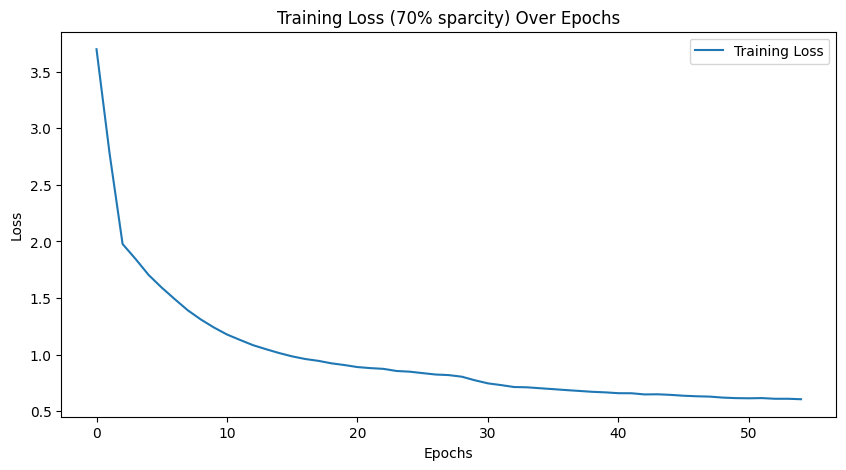

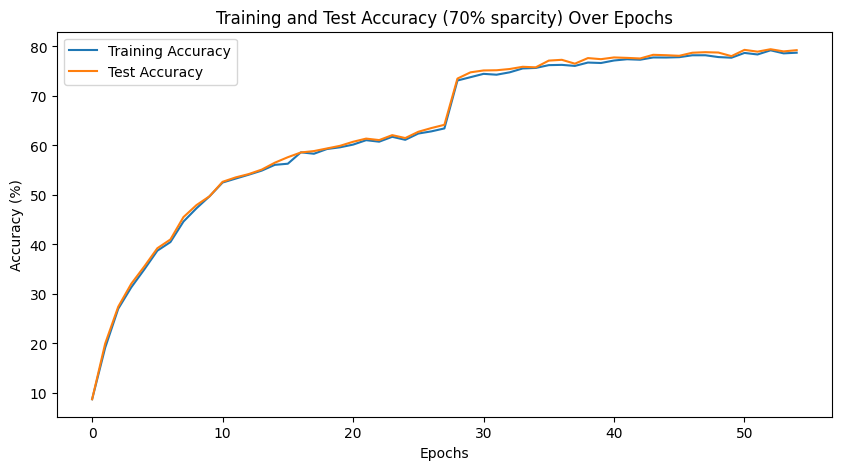

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy (70% sparcity) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [87]:
#TODO: Implement the function calculate_mae for table 3
# Debug the function calculate_mae
def calculate_mae(model, data_loader, device):
    model.eval()
    total_mae = 0.0
    total_count = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            mae = torch.abs(outputs - labels).mean()  # MAE calculation
            total_mae += mae.item() * images.size(0)
            total_count += images.size(0)

    average_mae = total_mae / total_count
    return average_mae

sparsity_levels = [0.8]
results = {}

for sparsity in sparsity_levels:
    model = SparseInvariantCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            sparse_images, masks = create_sparse_representations(images, sparsity)
            sparse_images, masks = sparse_images.to(device), masks.to(device)
            outputs = model(sparse_images, masks)
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1} completed for sparsity {sparsity*100}%')

    mae_performance = calculate_mae(model, test_loader, device)
    print(f'MAE at {sparsity*100}% sparsity: {mae_performance}')
    results[sparsity] = mae_performance

for sparsity, mae in results.items():
    print(f'Sparsity: {sparsity*100}%, MAE: {mae}')


Epoch 1 completed for sparsity 80.0%
Epoch 2 completed for sparsity 80.0%
Epoch 3 completed for sparsity 80.0%
Epoch 4 completed for sparsity 80.0%
Epoch 5 completed for sparsity 80.0%
Epoch 6 completed for sparsity 80.0%
Epoch 7 completed for sparsity 80.0%
Epoch 8 completed for sparsity 80.0%
Epoch 9 completed for sparsity 80.0%
Epoch 10 completed for sparsity 80.0%
Epoch 11 completed for sparsity 80.0%
Epoch 12 completed for sparsity 80.0%
Epoch 13 completed for sparsity 80.0%
Epoch 14 completed for sparsity 80.0%
Epoch 15 completed for sparsity 80.0%
Epoch 16 completed for sparsity 80.0%
Epoch 17 completed for sparsity 80.0%
Epoch 18 completed for sparsity 80.0%


KeyboardInterrupt: 

Apparently, implementing backward pass besides using the subclass torch.autograd.Function i.e. PyTorch's automatic differentiation engine, autograd, will handle the backward pass is better in accuracy metric

In [ ]:
# TODO: visualize the results like in the paper and compare the results with the paper?